In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Padronização global de estilo e resolução dos plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Carrega todos os dataframes
try:
    causality_all_df = pd.read_csv('./outputs/sfi2-paper-analysis/default_experiment/multi_round_analysis/multi_round_causality_all.csv')
    correlation_all_df = pd.read_csv('./outputs/sfi2-paper-analysis/default_experiment/multi_round_analysis/multi_round_correlation_all.csv')
    impact_stats_df = pd.read_csv('./outputs/sfi2-paper-analysis/default_experiment/multi_round_analysis/multi_round_impact_aggregated_stats.csv')
    print("Arquivos iniciais carregados com sucesso!")
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivos: {e}. \nVerifique se os arquivos CSV estão no mesmo diretório que este notebook.")

Arquivos iniciais carregados com sucesso!


In [2]:
# Código para criar o analise_avancada.csv (exatamente como antes)
try:
    print("Construindo o dataset avançado...")

    # 1. Agrega informações de causalidade
    score_threshold = causality_all_df['score'].quantile(0.75)
    causality_all_df['is_significant'] = ((causality_all_df['p-value'] < 0.05) | (causality_all_df['score'] > score_threshold)).fillna(False)
    causality_agg = causality_all_df.groupby(['phase', 'metric', 'source', 'target']).agg(
        mean_p_value=('p-value', 'mean'),
        mean_score=('score', 'mean'),
        significant_frequency=('is_significant', 'sum')
    ).reset_index()

    # 2. Prepara dados de correlação
    correlation_all_df['tenant_pair'] = correlation_all_df.apply(lambda r: '-'.join(sorted([r['tenant1'], r['tenant2']])), axis=1)
    causality_agg['tenant_pair'] = causality_agg.apply(lambda r: '-'.join(sorted([r['source'], r['target']])), axis=1)
    correlation_all_df.rename(columns={'metric_name': 'metric'}, inplace=True)
    
    # 3. Prepara dados de impacto
    impact_source_df = impact_stats_df.rename(columns={'tenant_id': 'source', 'metric_name': 'metric', 'mean_cohen_d': 'source_mean_cohen_d', 'mean_percentage_change': 'source_mean_percentage_change'})
    impact_target_df = impact_stats_df.rename(columns={'tenant_id': 'target', 'metric_name': 'metric', 'mean_cohen_d': 'target_mean_cohen_d', 'mean_percentage_change': 'target_mean_percentage_change'})

    # 4. Faz o merge de tudo
    df_adv = pd.merge(causality_agg, correlation_all_df[['phase', 'metric', 'tenant_pair', 'mean_correlation']], on=['phase', 'metric', 'tenant_pair'], how='left')
    df_adv = pd.merge(df_adv, impact_source_df[['metric', 'source', 'source_mean_percentage_change']], on=['metric', 'source'], how='left')
    df_adv = pd.merge(df_adv, impact_target_df[['metric', 'target', 'target_mean_percentage_change']], on=['metric', 'target'], how='left')
    
    df_adv = df_adv.drop(columns=['tenant_pair']).fillna(0)

    # 5. Salva o novo CSV
    file_name = 'analise_avancada.csv'
    df_adv.to_csv(file_name, index=False)
    
    print(f"Dataset avançado '{file_name}' foi gerado com sucesso.")
    print("\nVisualização do novo dataset:")
    print(df_adv.head())

except Exception as e:
    print(f"Ocorreu um erro ao gerar o arquivo: {e}")

Construindo o dataset avançado...
Dataset avançado 'analise_avancada.csv' foi gerado com sucesso.

Visualização do novo dataset:
          phase     metric      source      target  mean_p_value  mean_score  \
0  1 - Baseline  cpu_usage  tenant-cpu  tenant-dsk      0.170323    0.176874   
1  1 - Baseline  cpu_usage  tenant-cpu  tenant-mem      0.671409    0.081444   
2  1 - Baseline  cpu_usage  tenant-cpu  tenant-ntk      0.287363    0.196141   
3  1 - Baseline  cpu_usage  tenant-dsk  tenant-cpu      0.293814    0.141920   
4  1 - Baseline  cpu_usage  tenant-dsk  tenant-mem      0.001646    0.102709   

   significant_frequency  mean_correlation  source_mean_percentage_change  \
0                      1         -0.268619                     -99.756689   
1                      0         -0.235134                     -99.756689   
2                      1          0.353041                     -99.756689   
3                      1         -0.268619                       4.360521   
4    

In [16]:
import pandas as pd
import altair as alt

# --- Bloco de Configuração ---
salvar_imagens = True
alt.renderers.enable('default')

try:
    # --- 1. PREPARAÇÃO DOS DADOS (usando Pandas) ---
    # (Nenhuma mudança aqui, tudo continua igual)
    df_adv = pd.read_csv('analise_avancada.csv')
    display_names = {
        'cpu_usage': 'Uso de CPU (%)',
        'memory_usage': 'Uso de Memória (%)',
        'disk_usage': 'Uso de Disco (%)',
        'network_total_bandwidth': 'Banda de Rede (MB/s)',
        'disk_throughput_total': 'Vazão de Disco (MB/s)'
    }
    df_plot = df_adv[df_adv['target_mean_percentage_change'] < 0].copy()
    df_plot['metric_display'] = df_plot['metric'].map(display_names)
    df_plot['risk_type'] = 'Frequente'
    df_plot.loc[(df_plot['significant_frequency'] < 3) &
                (df_plot['target_mean_percentage_change'] < -20),
                'risk_type'] = 'Silencioso e Perigoso'
    df_plot['bubble_size'] = abs(df_plot['mean_correlation'])

    # --- 2. CONSTRUÇÃO DO GRÁFICO (usando Altair) ---

    # Camada 1: O Scatter Plot principal (sem mudanças)
    scatter_plot = alt.Chart(df_plot).mark_point(
        opacity=0.75,
        stroke='black',
        strokeWidth=0.6,
        filled=True
    ).encode(
        x=alt.X('significant_frequency:Q',
                title='Frequência Causal (Quão "Silencioso" é o Link)',
                scale=alt.Scale(zero=False)),
        y=alt.Y('target_mean_percentage_change:Q',
                title='Impacto Percentual no Alvo (Quão "Perigoso" é o Link)',
                axis=alt.Axis(labelExpr="datum.label + '%'")),
        color=alt.Color('metric_display:N', title='Métrica Afetada'),
        
        # <-- MUDANÇA 2: O TÍTULO DA LEGENDA AGORA É A EXPLICAÇÃO
        shape=alt.Shape(
            'risk_type:N',
            title='Risco', # Título mais descritivo
            scale=alt.Scale(
                domain=['Frequente', 'Silencioso e Perigoso'],
                range=['circle', 'cross']
            )
        ),
        size=alt.Size('bubble_size:Q',
                      title='Correlação Média',
                      scale=alt.Scale(range=[50, 1500])),
        tooltip=[
            alt.Tooltip('metric_display', title='Métrica'),
            alt.Tooltip('significant_frequency', title='Frequência'),
            alt.Tooltip('target_mean_percentage_change', title='Impacto', format='.1f'),
            alt.Tooltip('mean_correlation', title='Correlação', format='.2f'),
            alt.Tooltip('risk_type', title='Tipo de Risco')
        ]
    ).properties(
        width=800,
        height=500,
        title='Análise Investigativa: Mapa de Riscos Ocultos do Sistema'
    ).interactive()

    # Camada 2: Linhas de referência (agora opcionais, mas ajudam a guiar o olho)
    rule_h = alt.Chart(pd.DataFrame({'y': [-20]})).mark_rule(color='red', strokeDash=[5,5], opacity=0.5).encode(y='y:Q')
    rule_v = alt.Chart(pd.DataFrame({'x': [3]})).mark_rule(color='red', strokeDash=[5,5], opacity=0.5).encode(x='x:Q')

    # <-- MUDANÇA 1: A CAMADA DO "SHADER" (ÁREA SOMBREADA)
    # Criamos um DataFrame que define os cantos do nosso retângulo
    # Usamos os limites dos dados para tornar o retângulo dinâmico
    y_min = df_plot['target_mean_percentage_change'].min() - 5 # Um pouco de folga
    
    shaded_data = pd.DataFrame([
        {'x1': 0, 'x2': 3, 'y1': -20, 'y2': y_min}
    ])
    
    shaded_area = alt.Chart(shaded_data).mark_rect(
        fill='red',       # Cor do preenchimento
        opacity=0.15      # Nível de transparência
    ).encode(
        x='x1:Q',
        x2='x2:Q',
        y='y1:Q',
        y2='y2:Q'
    )

    # --- 3. COMBINAÇÃO FINAL ---
    # <-- MUDANÇA 3: A ORDEM DAS CAMADAS IMPORTA! O SHADER VEM PRIMEIRO!
    final_chart = shaded_area + scatter_plot + rule_h + rule_v

    final_chart.display()

    if salvar_imagens:
        print("\nIniciando o salvamento das imagens...")
        final_chart.save('mapa_de_riscos_com_shader.png', scale_factor=3.0)
        print("-> Imagem salva como 'mapa_de_riscos_com_shader.png'")
        final_chart.save('mapa_de_riscos_com_shader.svg')
        print("-> Imagem salva como 'mapa_de_riscos_com_shader.svg'")

except FileNotFoundError:
    print("Erro: O arquivo 'analise_avancada.csv' não foi encontrado. Verifique o caminho.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

alt.LayerChart(...)


Iniciando o salvamento das imagens...
Ocorreu um erro inesperado: Saving charts in 'png' format requires the vl-convert-python package: see https://altair-viz.github.io/user_guide/saving_charts.html#png-svg-and-pdf-format


/tmp/ipykernel_7674/891960521.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='mean_negative_impact', data=data, ax=ax, palette=plot_data[i]['palette'])
/tmp/ipykernel_7674/891960521.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y='mean_negative_impact', data=data, ax=ax, palette=plot_data[i]['palette'])


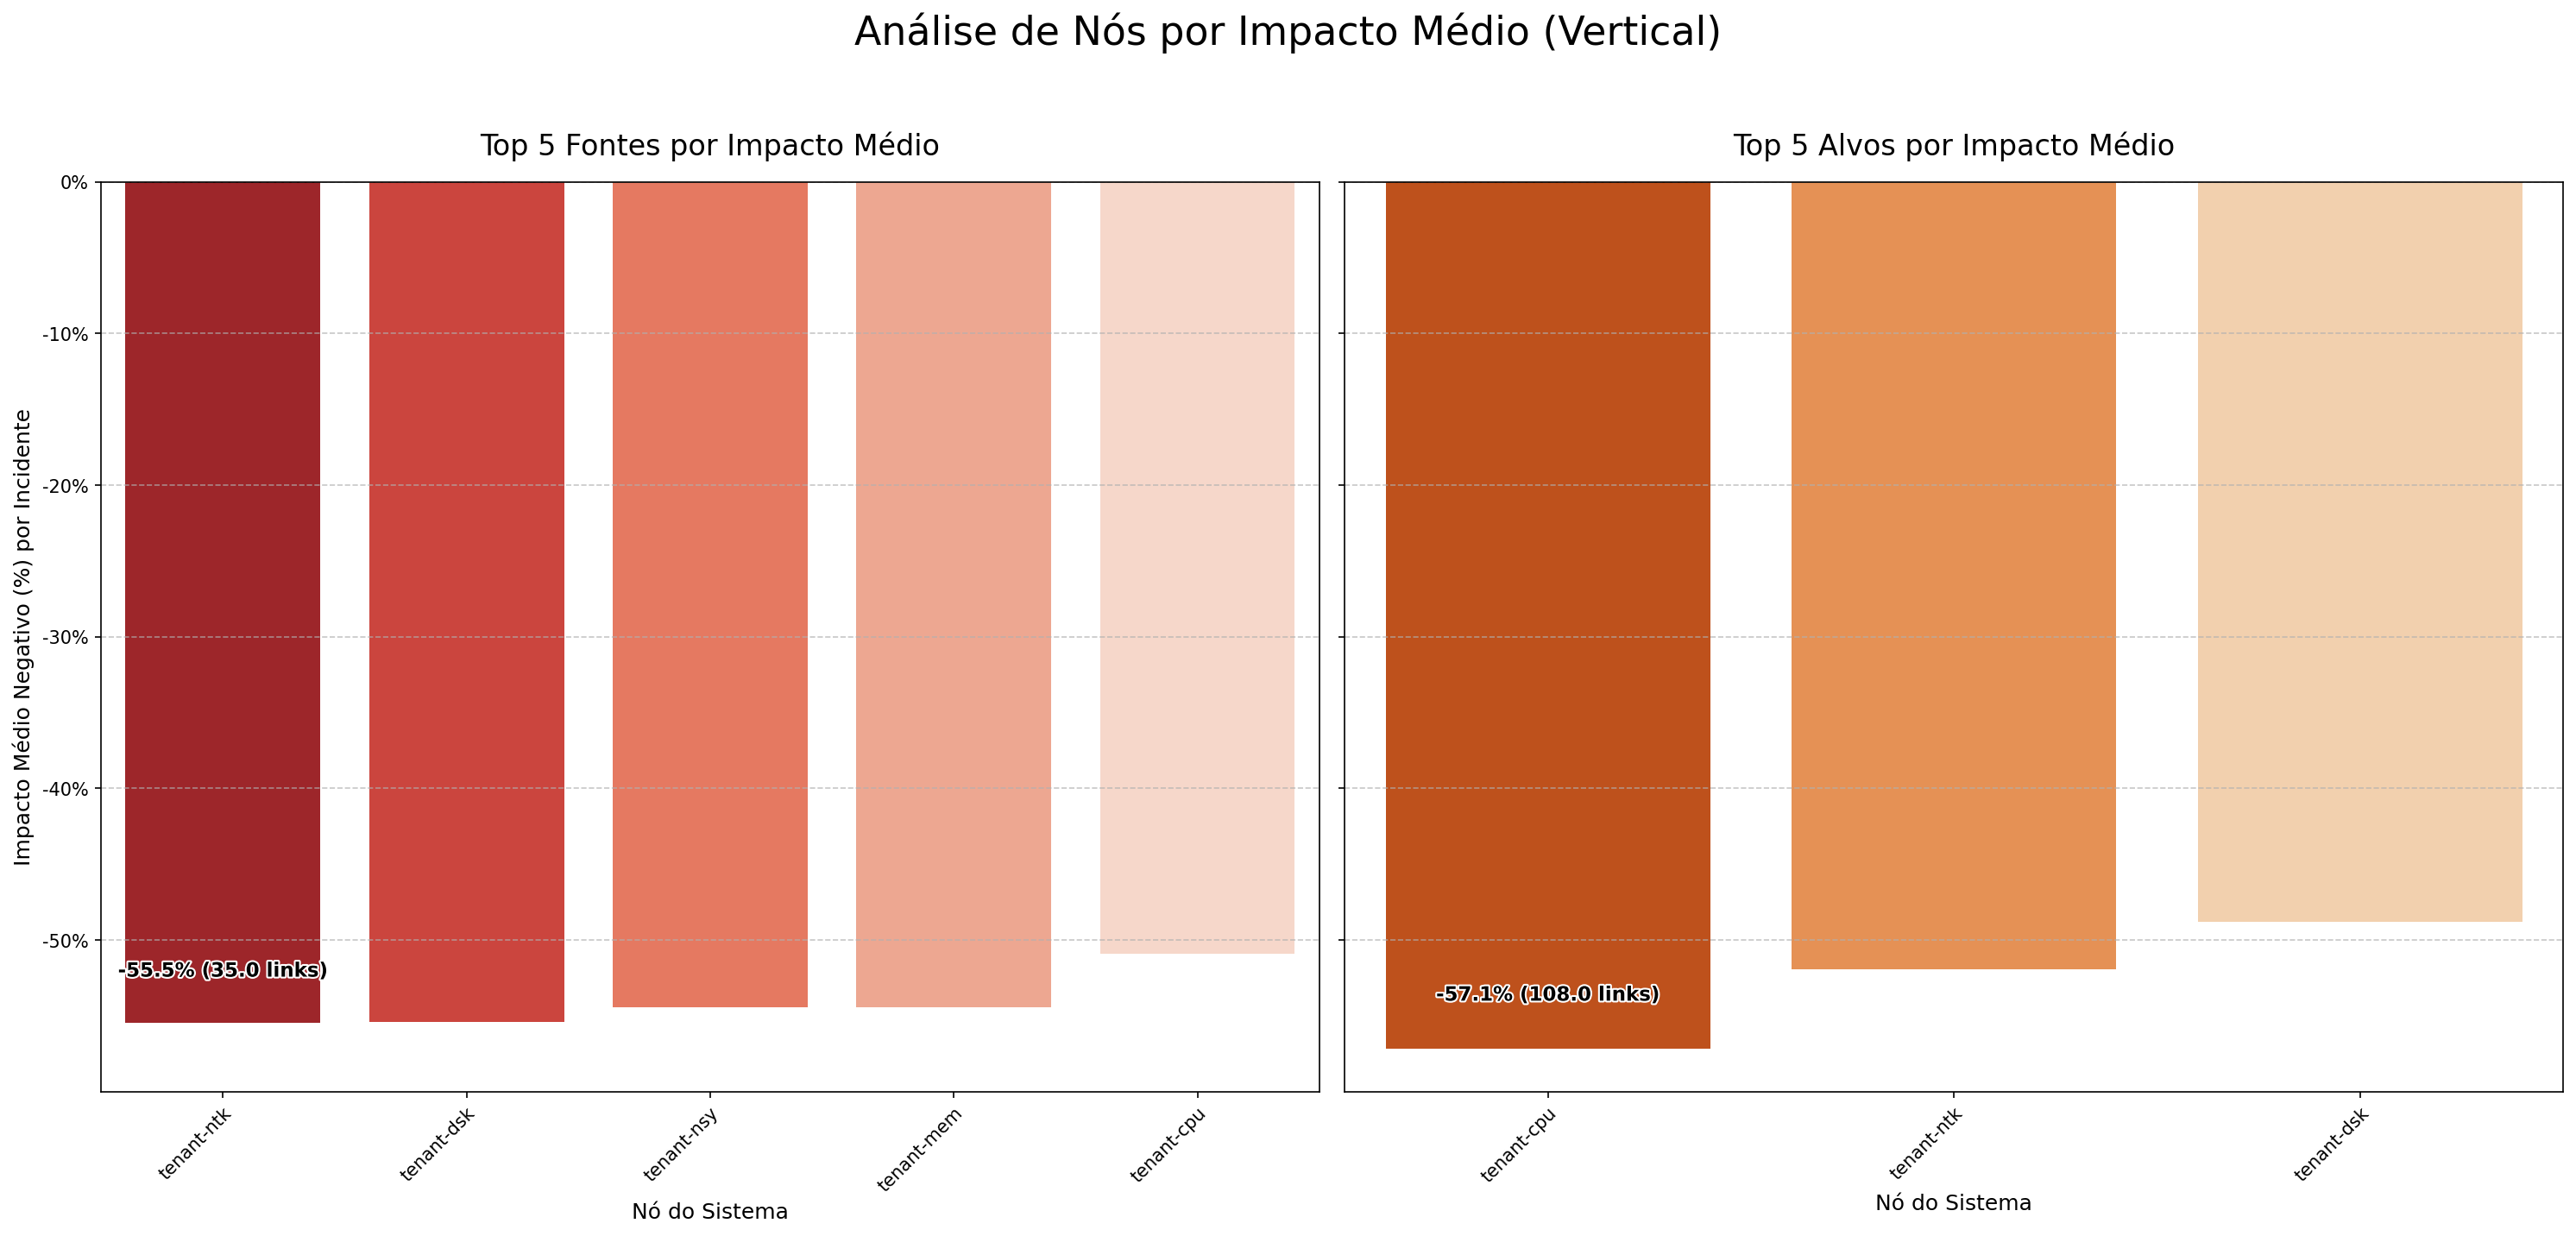

Painel vertical final com rótulos internos gerado com sucesso.


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as path_effects

# --- Preparação dos Dados ---
df_adv = pd.read_csv('analise_avancada.csv')
df_neg = df_adv[df_adv['target_mean_percentage_change'] < 0].copy()

# --- Agregação por NÓ DE ORIGEM (SOURCE) - MÉDIA ---
source_impact = df_neg.groupby('source').agg(
    mean_negative_impact=pd.NamedAgg(column='target_mean_percentage_change', aggfunc='mean'),
    incident_count=pd.NamedAgg(column='source', aggfunc='count')
).sort_values(by='mean_negative_impact', ascending=True).head(5)

# --- Agregação por NÓ DE DESTINO (TARGET) - MÉDIA ---
target_impact = df_neg.groupby('target').agg(
    mean_negative_impact=pd.NamedAgg(column='target_mean_percentage_change', aggfunc='mean'),
    incident_count=pd.NamedAgg(column='target', aggfunc='count')
).sort_values(by='mean_negative_impact', ascending=True).head(5)

# --- Geração da Visualização Final ---
plt.style.use('default')
plt.close('all')

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True, dpi=150)
fig.suptitle('Análise de Nós por Impacto Médio (Vertical)', fontsize=22, y=0.98)

plot_data = {
    0: {'data': source_impact, 'palette': 'Reds_r', 'title': 'Top 5 Fontes por Impacto Médio'},
    1: {'data': target_impact, 'palette': 'Oranges_r', 'title': 'Top 5 Alvos por Impacto Médio'}
}

for i, ax in enumerate(axes):
    data = plot_data[i]['data']
    sns.barplot(x=data.index, y='mean_negative_impact', data=data, ax=ax, palette=plot_data[i]['palette'])
    
    ax.set_title(plot_data[i]['title'], fontsize=16, pad=15)
    ax.set_xlabel('Nó do Sistema', fontsize=12)
    ax.set_ylabel('Impacto Médio Negativo (%) por Incidente' if i == 0 else '', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    formatter = mticker.FuncFormatter(lambda val, pos: f'{int(val)}%')
    ax.yaxis.set_major_formatter(formatter)

    # --- RÓTULOS DE DADOS ADICIONADOS DENTRO DAS BARRAS VERTICAIS ---
    for j, bar in enumerate(ax.containers[0]):
        bar_height = bar.get_height()
        incident_count = data.iloc[j]['incident_count']
        label_text = f'{bar_height:.1f}% ({incident_count} links)'
        
        # Posiciona o texto um pouco acima da base da barra (que é negativa)
        text_y_position = bar_height + (abs(bar_height) * 0.05)

        txt = ax.text(
            x=bar.get_x() + bar.get_width() / 2,
            y=text_y_position,
            s=label_text,
            ha='center',
            va='bottom', # Alinha pela base do texto
            color='black',
            weight='bold',
            fontsize=11
        )
        # Adiciona o contorno branco para legibilidade
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                              path_effects.Normal()])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('painel_vertical_com_rotulos.png', dpi=300)
plt.show()

print("Painel vertical final com rótulos internos gerado com sucesso.")